This notebook aims at depicting how an artificial neural network learns from the MNIST dataset.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import numpy as np

tf.keras.__version__

'2.4.0'

In [2]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# shuffle the data
idx_perm = np.random.RandomState(101).permutation(train_images.shape[0])
train_images, train_labels = train_images[idx_perm], train_labels[idx_perm]

# rescale the data as floating-point within [0, 1] (suitable for training)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

print(train_labels.shape)
print(train_images.shape)

print(test_labels.shape)
print(test_images.shape)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


In [3]:
# convert to one-hot encoding (make data suitable for training)
from keras.utils import to_categorical

train_labels_enc = to_categorical(train_labels)
test_labels_enc = to_categorical(test_labels)

print(train_labels_enc)
print(test_labels_enc)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
# Let's use a single layer to see how the input units map to each
# of the 10 neurons of the layer.

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(10, activation='softmax', input_shape=(28*28,)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
model.fit(train_images, train_labels_enc, epochs=7, batch_size=128)

Epoch 1/7
469/469 [==============================] - 1s 1ms/step - loss: 0.6081 - accuracy: 0.8453
Epoch 2/7
469/469 [==============================] - 1s 2ms/step - loss: 0.3312 - accuracy: 0.9073
Epoch 3/7
469/469 [==============================] - 1s 1ms/step - loss: 0.3022 - accuracy: 0.9151
Epoch 4/7
469/469 [==============================] - 1s 1ms/step - loss: 0.2887 - accuracy: 0.9193
Epoch 5/7
469/469 [==============================] - 1s 2ms/step - loss: 0.2804 - accuracy: 0.9218
Epoch 6/7
469/469 [==============================] - 1s 1ms/step - loss: 0.2753 - accuracy: 0.9236
Epoch 7/7
469/469 [==============================] - 1s 1ms/step - loss: 0.2710 - accuracy: 0.9243


In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels_enc)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 829us/step - loss: 0.2698 - accuracy: 0.9256
test_acc: 0.925599992275238


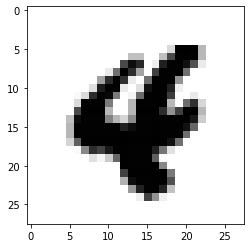

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
The digit is 4


In [8]:
# Let's make a prediction
index = np.random.randint(0, 1000)  # random pick a test image

plt.imshow(test_images[index].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

res = model.predict(test_images)[index]
print(np.around(res))
print('The digit is %d' % np.where(res == np.max(res)))


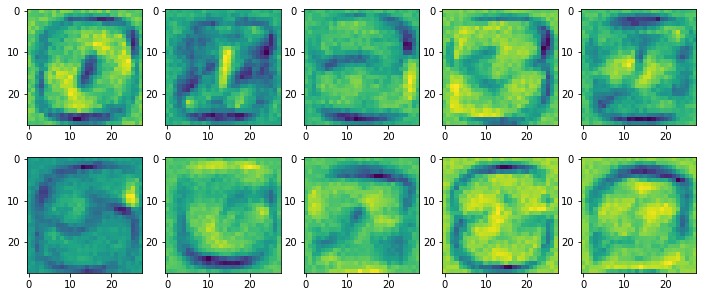

After a little adjustment:


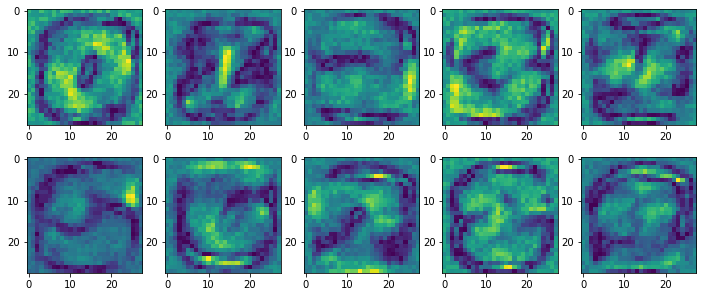

In [9]:
# But why the network can classify the digit images?
# Let's show the weights to see some insights into what's stored in the network
layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((layer_weights[:, i]).reshape(28, 28))
plt.show()

# add 0.5 to every weight to show the output more clearly 
print("After a little adjustment:")
fig = plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.abs((layer_weights[:, i] + 0.5).reshape(28, 28)))
plt.show()

The weight matrix of each of the 10 neurons looks a somewhat **blurry** version of each of the 10 digits. We can anticipate that the neuron responsible for classifying 2's should have a high value because its weights are such that high weights tend to align with pixels tending to be high in 2's. But why blurry? Blurry (and "thicker digits" on the plots) is not a bad thing but a really good thing that implies the network has learned the various ways of hand writing of digits. 

Let us make a really bad training set that contains only one way of hand writing the 10 digits. We extract only one version of the digit images of the 10 digits from train_images, so only 10 images. Then we use them to form a dataset of 6,000 images.

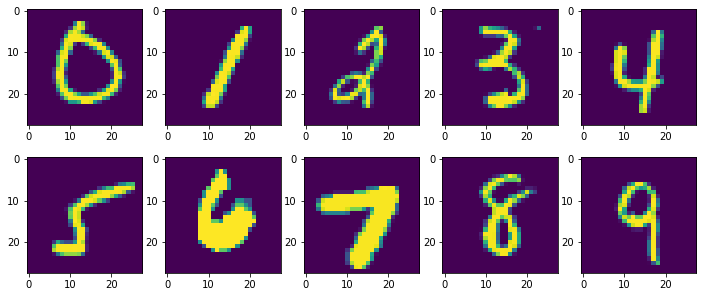

(10, 784)
(6000, 784)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
for x in range(10):
    for i in range(10000):
        if train_labels[i] == x:
            if x == 0:
                images0_9 = np.expand_dims(train_images[i], axis=0)
            else:
                tmp = np.expand_dims(train_images[i], axis=0) 
                images0_9 = np.concatenate((images0_9, tmp))
            break

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images0_9[i].reshape(28, 28))
plt.show()

bad_train_images = images0_9.copy()
print(bad_train_images.shape)
for i in range(1, 600):
    bad_train_images = np.concatenate((bad_train_images, images0_9))
    
print(bad_train_images.shape)

bad_train_labels_enc = to_categorical([x for x in range(10)] * 600)
print(bad_train_labels_enc)

In [11]:
model = models.Sequential()
model.add(layers.Dense(10, activation='softmax', input_shape=(28*28,)))
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(bad_train_images, bad_train_labels_enc, epochs=7, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
47/47 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.9487
Epoch 2/7
47/47 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 1.0000
Epoch 3/7
47/47 [==============================] - 0s 2ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 4/7
47/47 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 5/7
47/47 [==============================] - 0s 2ms/step - loss: 2.3842e-04 - accuracy: 1.0000
Epoch 6/7
47/47 [==============================] - 0s 1ms/step - loss: 3.9320e-05 - accuracy: 1.0000
Epoch 7/7
47/47 [==============================] - 0s 1m

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels_enc)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 885us/step - loss: 2.1023 - accuracy: 0.4895
test_acc: 0.4894999861717224


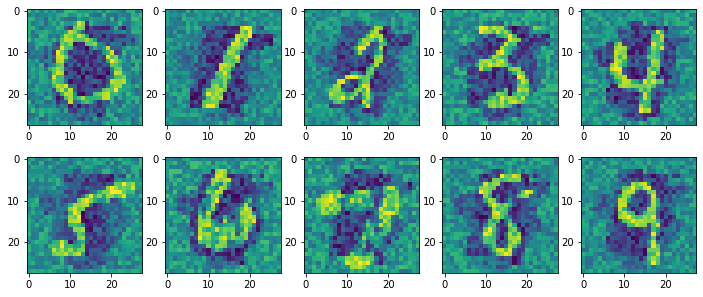

In [13]:
# Let's show the weights of this network.
layer_weights = model.layers[0].get_weights()[0]
layer_biases  = model.layers[0].get_weights()[1]

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((layer_weights[:, i]).reshape(28, 28))
plt.show()

This time, the weights look much the same as the digit images. But this is not learning at all but memorizing! That's why the prediction accuracy becomes very poor when tested with test images which consist of different hand writing styles.